# PREDICTION SALES

Predict sales in Q4 using 3 method:
1. Prophet
2. ARIMA
3. XGBoost

## XGBoost

In [2]:
# Install `gdown` library to download files from Google Drive to Google Colab.
!pip install gdown

In [3]:
# Import Library
import pandas as pd   # Library used to analyze data.
import numpy as np    # Library used to analyze data.
import seaborn as sns # Library used to do visualization.
import gdown          # library used to download files from Google Drive.
import pickle         # Library used to store and read files in pickle format.
import matplotlib.pyplot as plt

#--------------#

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [4]:
# Download Dataset from Google Drive.
url = "https://drive.google.com/file/d/1aDhLBzjGMb3FO3ORqHae4C5mkiHqFdpi/view?usp=drive_link"
output = 'df.pickle'
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1aDhLBzjGMb3FO3ORqHae4C5mkiHqFdpi
To: /content/df.pickle
100%|██████████| 67.9M/67.9M [00:02<00:00, 33.6MB/s]


'df.pickle'

In [9]:
# Load the dataset into Dataframe form.
df = pd.read_pickle('/content/df.pickle')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df

,id,category,product_name,units,store_name,city,loc,open_date,cost,price
date,,,,,,,,,,
2017-01-01,1,Games,Chutes & Ladders,1,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,9.99,12.99
2017-01-01,2,Toys,Action Figure,1,Maven Toys Puebla 2,Puebla,Downtown,2011-04-01,9.99,15.99
2017-01-01,3,Games,Deck Of Cards,1,Maven Toys Mexicali 1,Mexicali,Commercial,2003-12-13,3.99,6.99
2017-01-01,4,Sports & Outdoors,Dart Gun,1,Maven Toys Saltillo 2,Saltillo,Commercial,2016-03-23,11.99,15.99
2017-01-01,5,Toys,Lego Bricks,1,Maven Toys Puebla 3,Puebla,Residential,2014-12-27,34.99,39.99
...,...,...,...,...,...,...,...,...,...,...
2018-09-30,829258,Art & Crafts,Magic Sand,1,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,13.99,15.99
2018-09-30,829259,Games,Uno Card Game,1,Maven Toys San Luis Potosi 1,San Luis Potosi,Downtown,2007-05-19,3.99,7.99
2018-09-30,829260,Art & Crafts,Magic Sand,1,Maven Toys Guanajuato 2,Guanajuato,Commercial,2010-03-29,13.99,15.99


In [10]:
# Create a 'Revenue' column from the 'Units' and 'Price' columns.
df['revenue'] = df['units'] * df['price']

In [11]:
# Show information about dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 829262 entries, 2017-01-01 to 2018-09-30
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            829262 non-null  object        
 1   category      829262 non-null  object        
 2   product_name  829262 non-null  object        
 3   units         829262 non-null  int64         
 4   store_name    829262 non-null  object        
 5   city          829262 non-null  object        
 6   loc           829262 non-null  object        
 7   open_date     829262 non-null  datetime64[ns]
 8   cost          829262 non-null  float64       
 9   price         829262 non-null  float64       
 10  revenue       829262 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 75.9+ MB


In [12]:
# Grouping Revenue and Number of Stores based on date.
df = df.groupby('date').agg({
    'revenue': 'sum'
})

df

,revenue
date,
2017-01-01,21076.15
2017-01-02,19750.94
2017-01-03,11759.50
2017-01-04,14814.40
2017-01-05,19791.30
...,...
2018-09-26,15518.49
2018-09-27,18351.04
2018-09-28,25940.93


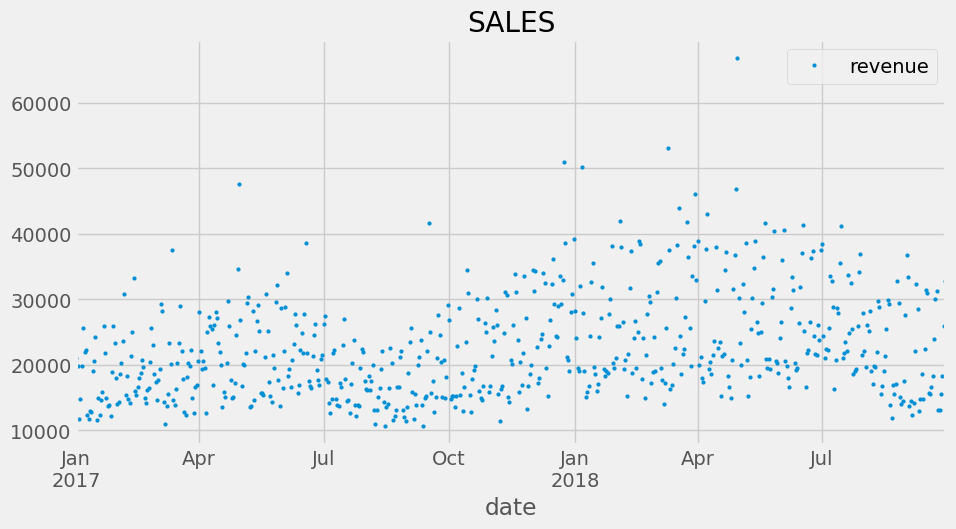

In [15]:
color_pal = sns.color_palette()
df.plot(style='.',
        figsize=(10,5),
        ms=4,
        color=color_pal[0],
        title='SALES')
plt.show()

In [18]:
# Insert the `prediction for the model` dataset to Pandas Dataframe.
df_xgb = df.copy()
# df_xgb.set_index('date', inplace=True)
df_xgb.tail()

,revenue
date,
2018-09-26,15518.49
2018-09-27,18351.04
2018-09-28,25940.93
2018-09-29,32757.10
2018-09-30,34718.33


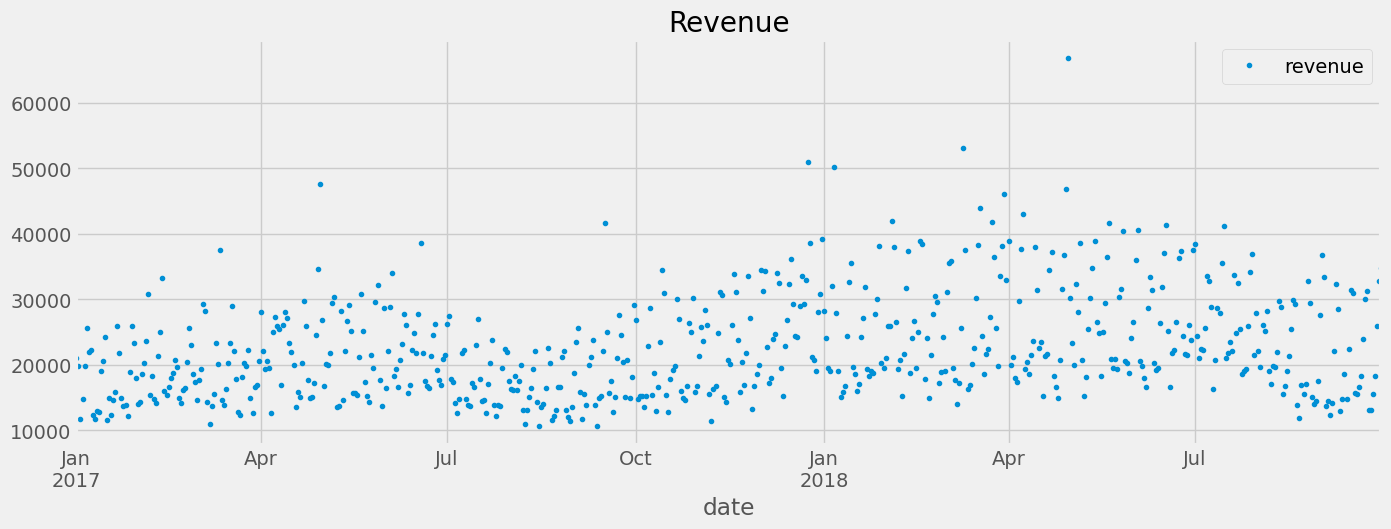

In [19]:
df_xgb.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Revenue')
plt.show()

### Outlier Analysis and removal

<Axes: ylabel='Frequency'>

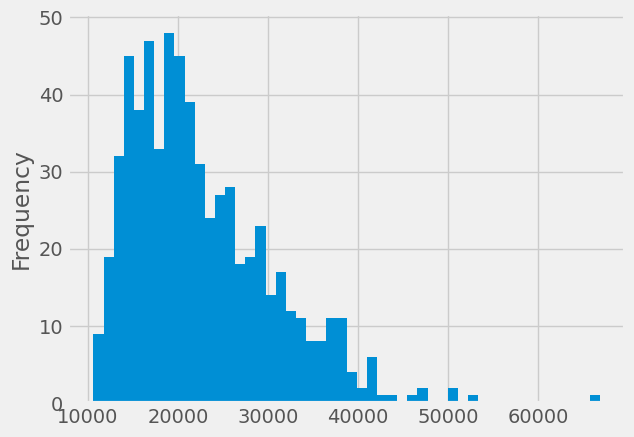

In [20]:
df_xgb['revenue'].plot(kind='hist', bins=50)

<Axes: title={'center': 'Outliers'}, xlabel='date'>

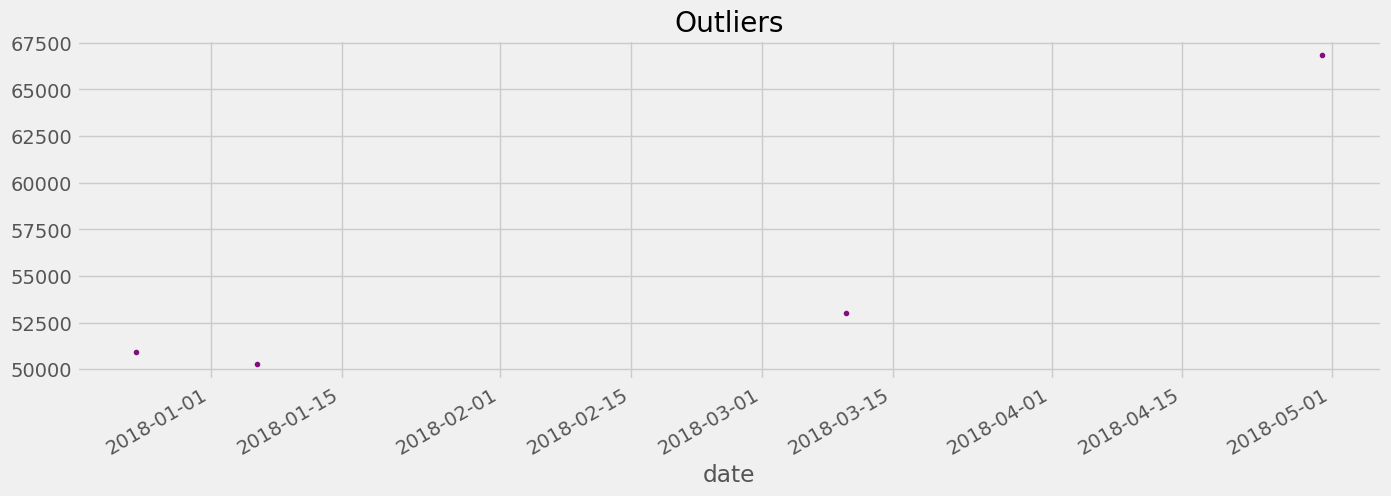

In [21]:
df_xgb.query('revenue > 50000')['revenue'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [22]:
df_clean = df_xgb.query('revenue < 50000').copy()

### Train / Test Split

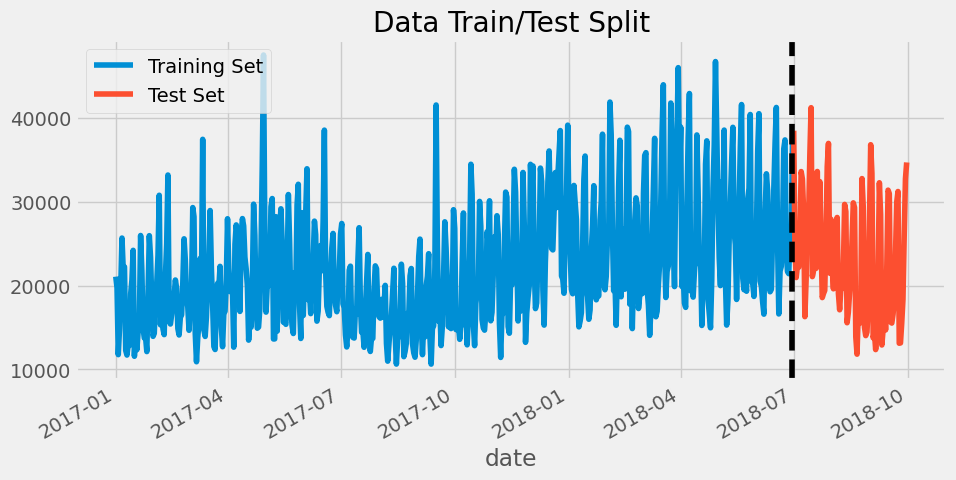

In [23]:
split_date = '30-Jun-2018'
train_xgb = df_clean.loc[df_clean.index <= split_date].copy()
test_xgb = df_clean.loc[df_clean.index > split_date].copy()

fig, ax = plt.subplots(figsize=(10, 5))
train_xgb.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_xgb.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Forecasting Horizon Explained
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [24]:
df = df_xgb.copy()

In [25]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [26]:
df.head()

,revenue,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2017-01-01,21076.15,6,1,1,2017,1,1,52
2017-01-02,19750.94,0,1,1,2017,2,2,1
2017-01-03,11759.50,1,1,1,2017,3,3,1
2017-01-04,14814.40,2,1,1,2017,4,4,1
2017-01-05,19791.30,3,1,1,2017,5,5,1


Visualize our Feature / Target Relationship

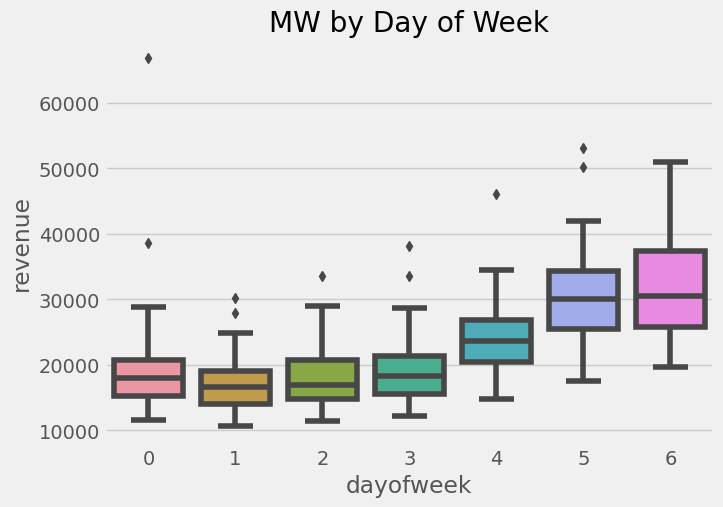

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, x='dayofweek', y='revenue')
ax.set_title('MW by Day of Week')
plt.show()

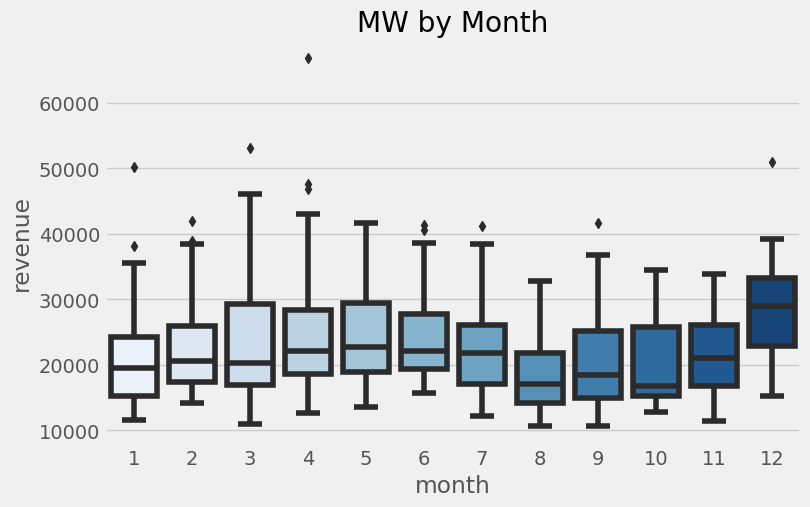

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, x='month', y='revenue', palette='Blues')
ax.set_title('MW by Month')
plt.show()

### Create our Model

In [29]:
train_xgb = create_features(train_xgb)
test_xgb = create_features(test_xgb)

FEATURES1 = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET1 = 'revenue'

X_train = train_xgb[FEATURES1]
y_train = train_xgb[TARGET1]

X_test = test_xgb[FEATURES1]
y_test = test_xgb[TARGET1]

In [30]:
reg1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=310,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg1.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:35:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23263.08511	validation_1-rmse:24175.81463
[100]	validation_0-rmse:9457.77412	validation_1-rmse:8034.84696
[200]	validation_0-rmse:4955.61824	validation_1-rmse:4286.69698
[300]	validation_0-rmse:3762.78372	validation_1-rmse:3922.70771
[309]	validation_0-rmse:3717.21101	validation_1-rmse:3917.08214


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=310, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### Feature Importance

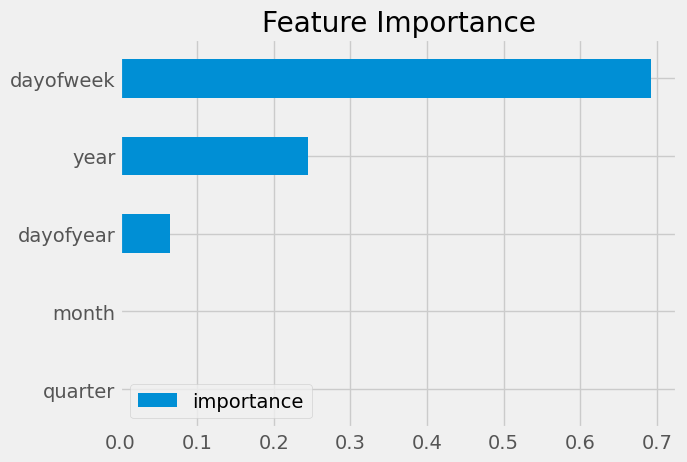

In [31]:
fi = pd.DataFrame(data=reg1.feature_importances_,
             index=reg1.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on Test

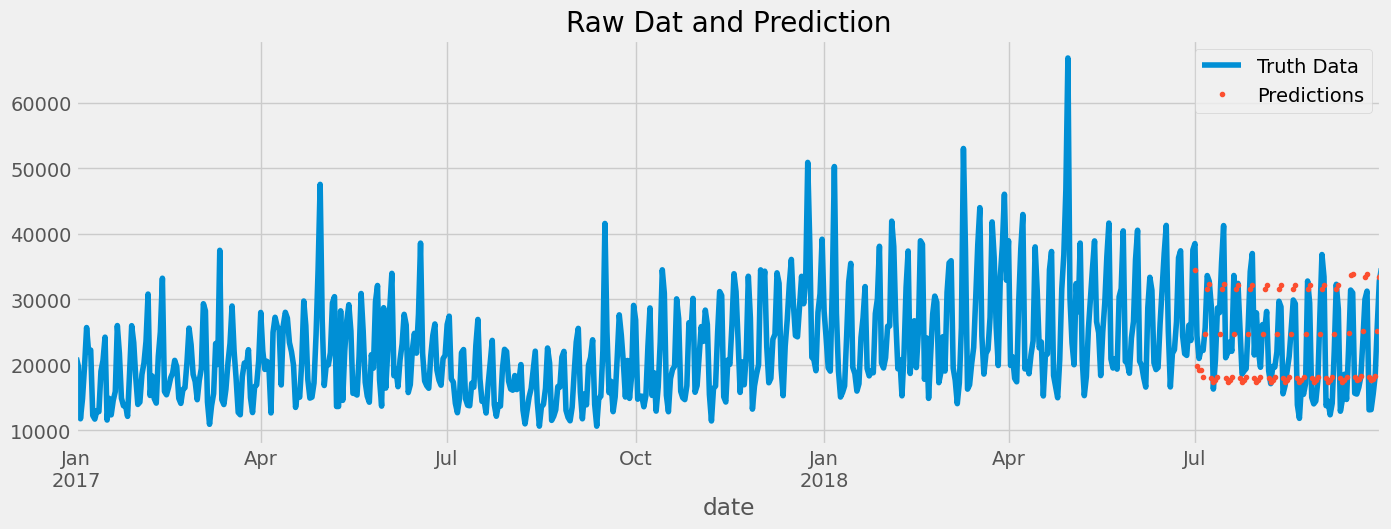

In [32]:
test_xgb['prediction'] = reg1.predict(X_test)
df = df_xgb.merge(test_xgb[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['revenue']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Check Accuracy Metric

In [33]:
score = np.sqrt(mean_squared_error(test_xgb['revenue'], test_xgb['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3917.08


In [34]:
mean_absolute_error(test_xgb['revenue'], test_xgb['prediction'])

3134.5555443274466

In [35]:
mean_absolute_percentage_error(test_xgb['revenue'], test_xgb['prediction'])

14.63694993295285

### Predict the future

In [36]:
# Create future dataframe
future1 = pd.date_range('2018-09-30','2018-12-31')
future_df1 = pd.DataFrame(index=future1)
future_df1['isFuture'] = True
df['isFuture'] = False
df_and_future1 = pd.concat([df, future_df1])
df_and_future1 = create_features(df_and_future1)

In [37]:
future_w_features1 = df_and_future1.query('isFuture').copy()
future_w_features1['revenue'] = reg1.predict(future_w_features1[FEATURES1])

In [38]:
future_w_features1.head()

,revenue,prediction,isFuture,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2018-09-30,33913.855469,NaN,True,6,3,9,2018,273,30,39
2018-10-01,18187.757812,NaN,True,0,4,10,2018,274,1,40
2018-10-02,17639.867188,NaN,True,1,4,10,2018,275,2,40
2018-10-03,17894.589844,NaN,True,2,4,10,2018,276,3,40
2018-10-04,18357.714844,NaN,True,3,4,10,2018,277,4,40


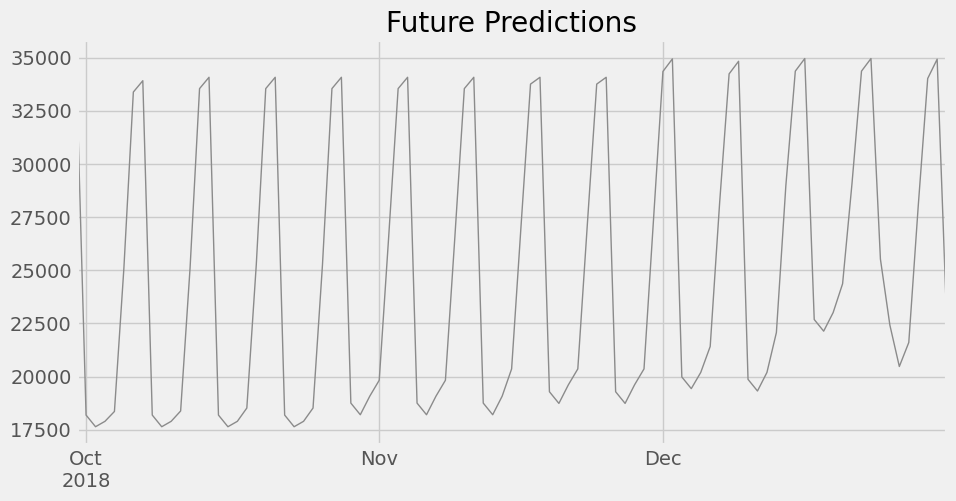

In [39]:
future_w_features1['revenue'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [40]:
df_xgb1 = df_xgb.copy()
combined_df1 = pd.concat([df_xgb1, future_w_features1])
combined_df1 = combined_df1[['revenue']]
combined_df1

,revenue
2017-01-01,21076.150000
2017-01-02,19750.940000
2017-01-03,11759.500000
2017-01-04,14814.400000
2017-01-05,19791.300000
...,...
2018-12-27,21601.763672
2018-12-28,28025.527344
2018-12-29,34018.054688
2018-12-30,34925.585938


<Axes: >

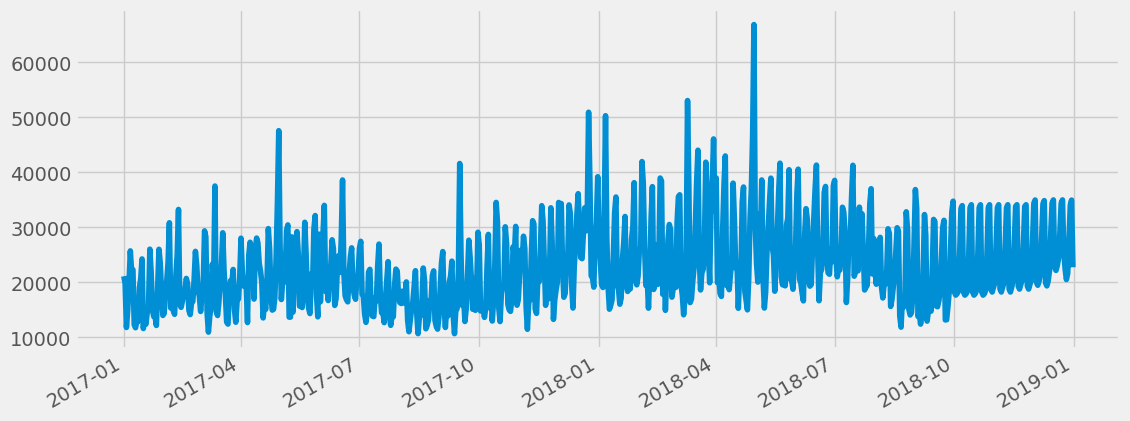

In [41]:
combined_df1['revenue'].plot(figsize=(12,5))

#### Save Pickle

In [42]:
# save to pickle
combined_df1.to_pickle('XGBoost_one.pickle')

Tableau

In [43]:
# save to excel
tableau = future_w_features1[['revenue']].reset_index().copy()
tableau['revenue'] = tableau['revenue'].round(2)
tableau.rename(columns={'index': 'date'}, inplace=True)
tableau['date'] = tableau['date'].dt.strftime('%Y-%m-%d')
tableau.to_excel('xgboost_revenue.xlsx', index=False)

### Prediction Revenue Q4

In [44]:
combined_df1 = combined_df1.reset_index()
combined_df1.rename(columns={'index': 'date'}, inplace=True)

In [45]:
forecast_q4_xgb = combined_df1[(combined_df1['date'] >= '2018-10-01') & (combined_df1['date'] <= '2018-12-31')]
sum_q4_xgb = forecast_q4_xgb.sum().round(2)
print(f'total perdict sales Q4 = {sum_q4_xgb}')

total perdict sales Q4 = revenue    2276855.15
dtype: float64
